In [3]:
import  pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import StratifiedKFold
from sklearn.manifold import TSNE

import matplotlib
%matplotlib inline
sns.set(font_scale=0.5)
plt.rcParams['figure.dpi'] = 150
pd.set_option("display.max_columns", None)

## Read data

In [5]:
df_data = pd.read_excel('..\..\data\Triage.xlsb',sheet_name='Data')

In [6]:
df_data.head()

,Phtriage,Htriage,Dischgto,Dischhome,DischICU,EMRGgroup,Time_in,Time_out,EDLOS,Kjonn,InICD10-code,InICD10-chapter,Aar,Mnd,DOW,Shift,nprDiagn,Out_ICD10-chapter,Age,24hmrt,7dmrt,30dmrt,Mrt_AND_OR_ICU,Triagestm
0,3.0,2.0,Bosted,1,0,HJERTE,0.254861,0.375000,173.0,Kvinne,I48,I,2012.0,2.0,Man-fre,Natt,NaN,A,74.0,0,0,0,0,1.0
1,4.0,4.0,OBS-post,0,0,MED,0.729167,0.729861,1.0,Kvinne,A09,A,2014.0,6.0,Man-fre,Kveld,A020,A,19.0,0,0,0,0,2.0
2,NaN,4.0,Med 6,0,0,XXXX,0.459028,0.459722,1.0,Mann,NaN,0,2015.0,4.0,Man-fre,Dag,A020,A,67.0,0,0,0,0,2.0
3,NaN,4.0,UMO 1,0,0,MED,0.584722,0.588194,5.0,Mann,R53,R,2016.0,10.0,Helg,Dag,A020,A,54.0,0,0,0,0,3.0
4,NaN,4.0,UMO 1,0,0,KIR,0.070833,0.080556,14.0,Mann,NaN,0,2016.0,6.0,Man-fre,Natt,A020,A,19.0,0,0,0,0,2.0


### Variable list

In [4]:
df_var = pd.read_excel('Emergency department 2012 to 17 datathon v1_3.xlsb',sheet_name='Variables')
df_var

,Kolonne1,Kolonne2,Kolonne3,Kolonne4,Kolonne5,Kolonne6
0,Variable name,Explanation,Type of variable,Comment 1,Comment 2,Comment 3
1,Phtriage,Pre hospital triage score,Categorical,1 to 5,Only available for patient presenting by ambul...,NaN
2,Htriage,Triage score in the emergency department,Categorical,1 to 5,NaN,NaN
3,Dischgto,Place of discharge,Categorical,Name of wards,Bosted=discharged home,NaN
4,Dischhome,Discharged home,Binary,1=yes,0=no,NaN
5,DischICU,Discharged to intensive care unit or to surgery,Binary,1=yes,0=no,NaN
6,EMRGgroup,Emergency group,Categorical,Name of emergency group,NaN,NaN
7,Time_in,Time of day at presentation,NaN,24-hour clock,NaN,NaN
8,Time_out,Time of day at discharge,NaN,24-hour clock,NaN,NaN
9,EDLOS,Lenght of stay in the emergency department,Numerical,Time in minutes,NaN,NaN


## Feature engineering

In [7]:
#Convert time in to hour only
df_data['Time_in_Hour'] = df_data['Time_in'].apply(lambda x: round(x* 86400/3600,0)).astype(object)

df_data['Out_ICD10-chapter'] = df_data['Out_ICD10-chapter'].astype(str)
df_data['InICD10-chapter'] = df_data['InICD10-chapter'].astype(str)

**Plot the length of stay - this is highly correlated with the triage score. This probably makes sense if severe/high risk patients are taken care of within a short time period**

Text(0.5, 1.0, 'EDLOS')

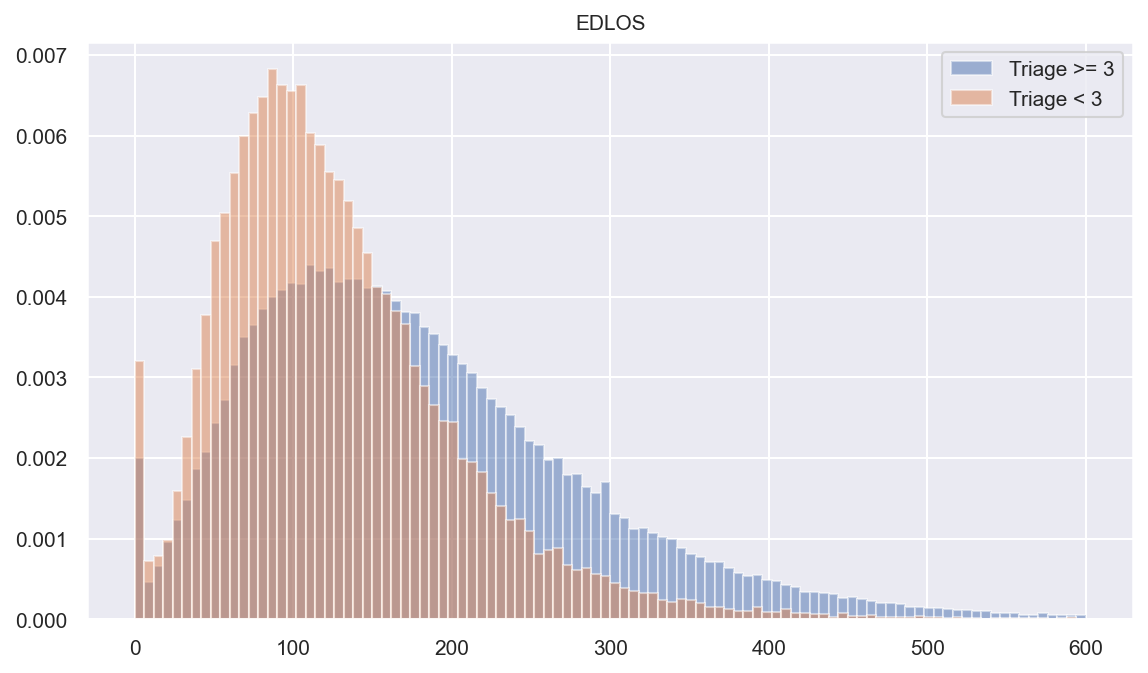

In [8]:
ax = df_data[(df_data.Htriage >=3) & (df_data['Mrt_AND_OR_ICU']>-1)].EDLOS.hist(density=True,alpha=0.5,range=[0,600],bins=100,figsize=(9,5),label='Triage >= 3')
df_data[(df_data.Htriage <3) & (df_data['Mrt_AND_OR_ICU']>-1)].EDLOS.hist(ax=ax,density=True,alpha=0.5,range=[0,600],bins=100,label='Triage < 3')
ax.set_xlabel('',fontsize = 10)
ax.set_ylabel('',fontsize = 10)
ax.legend(fontsize=10)
ax.tick_params(axis='both', labelsize=10)
ax.set_title('EDLOS',fontsize = 10)

**Distribution of triage score in the dataset**

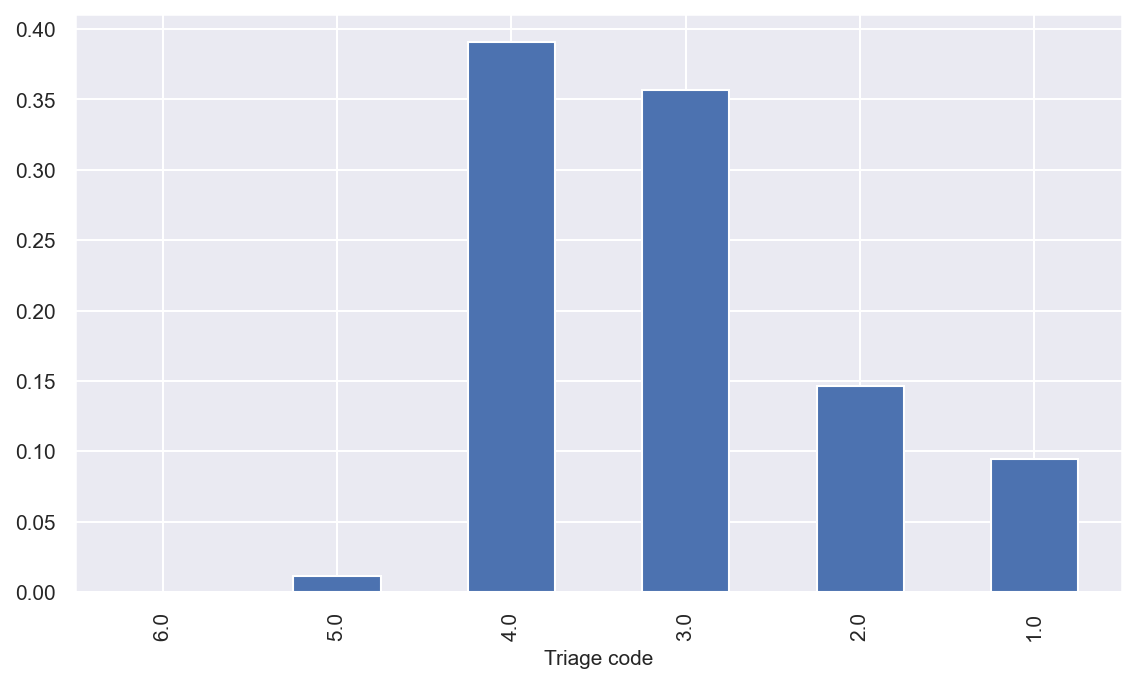

In [9]:
#df_data['Triage'] = pd.Categorical(df_data['akdb_HastegradBeskrivelse'], ["Blå", "Grønn", "Dec"])
ax = df_data.Htriage.value_counts(normalize=True).sort_index(ascending=False).plot(kind='bar',figsize=(9,5))
ax.set_xlabel('Triage code',fontsize = 10)
ax.set_ylabel('',fontsize = 10)
ax.tick_params(axis='both', labelsize=10)

# Modeling

In [34]:
#Helping function to perform cross-validation and plot ROC-curves
def cv_roc(X,y,estimator,cv,groups=None):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    
    for train, test in cv.split(X,y,groups):
        probas_ = estimator.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])

        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.1f)' % (i, roc_auc*100))

        i += 1
    plt.plot([0, 1], [0, 1], 'r--')

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)*3
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.1f $\pm$ %0.1f)' % (mean_auc*100, std_auc*100),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)*3
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 3 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

**Setup a machine learning pipeline**

Use Random forest classifier, and ordinal encoder for handling categoricals. Note that this should be changed to one hot encoding if using other non-tree like algorithms. 

In [9]:
num_pipe = make_pipeline(SimpleImputer(strategy="mean"))#,StandardScaler())
cat_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"),# fill_value="missing"),
   # OneHotEncoder(handle_unknown='ignore',sparse=False)
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
)

preprocessor = make_column_transformer(
    (num_pipe, selector(dtype_include=['int64','float64'])),
    (cat_pipe, selector(dtype_include=['object'])),
    n_jobs=2,
)

In [10]:


rf_clf = make_pipeline(
    preprocessor,
  # RandomUnderSampler(random_state=42),
    # xgb.XGBClassifier(use_label_encoder=False,eval_metric='logloss')
    RandomForestClassifier(random_state=42,class_weight="balanced")
   # BalancedRandomForestClassifier()
)


In [11]:
df_data.Htriage.value_counts(normalize=True)

4.0    0.390944
3.0    0.356495
2.0    0.146535
1.0    0.094760
5.0    0.011208
6.0    0.000058
Name: Htriage, dtype: float64

## Risk of misclassifying severe patients 

Population: Patients dead within 24 hours after presentation to the ED, transfer to ICU from the ED and/or transfer to the operation room (including coronary angiography)

Classification: Triage score >= 3 (1) vs < 3 (0)

In [12]:
df_mod = df_data[df_data.Age >= 18].copy()

In [13]:
features = ['EMRGgroup','Time_in_Hour','Kjonn','DOW','Shift','Age','InICD10-chapter','Triagestm']

X = df_mod.loc[df_mod.Mrt_AND_OR_ICU==1,features]
y = pd.Series(np.where(df_mod.loc[df_mod.Mrt_AND_OR_ICU==1,'Htriage']>=3,1,0))
y.value_counts(normalize=True)


0    0.850481
1    0.149519
dtype: float64

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9156 entries, 35 to 205185
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   EMRGgroup        9156 non-null   object 
 1   Time_in_Hour     9156 non-null   object 
 2   Kjonn            9155 non-null   object 
 3   DOW              9156 non-null   object 
 4   Shift            8562 non-null   object 
 5   Age              9156 non-null   float64
 6   InICD10-chapter  9156 non-null   object 
 7   Triagestm        8134 non-null   float64
dtypes: float64(2), object(6)
memory usage: 643.8+ KB


#### Random forest classification tree; 3-Fold cross validation; ROC-AUC

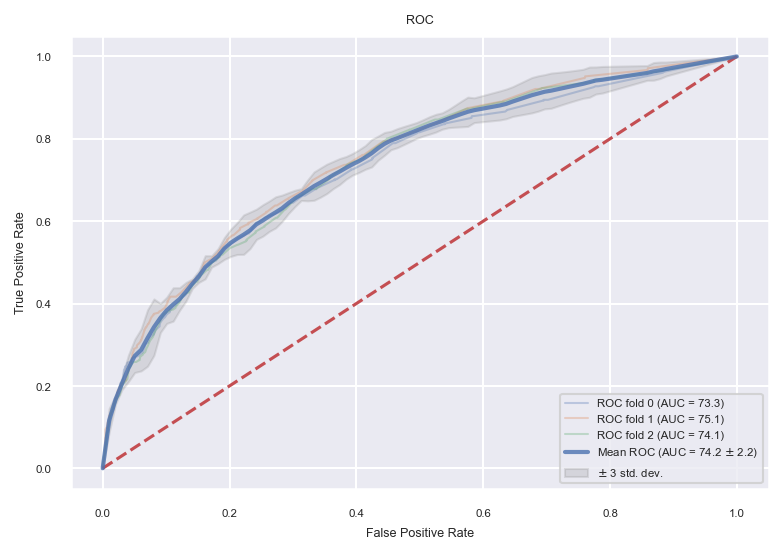

In [15]:
cv=StratifiedKFold(n_splits=3,shuffle=True)
cv_roc(X,y,rf_clf,cv)

### Feature importance by SHAP-value

In [16]:
import shap
shap.initjs()

In [17]:
preprocessor.fit_transform(X)

array([[71.,  3.,  6., ...,  1.,  0.,  1.],
       [77.,  2.,  2., ...,  1.,  0.,  1.],
       [83.,  2.,  6., ...,  1.,  0.,  1.],
       ...,
       [40.,  3.,  6., ...,  0.,  1.,  5.],
       [54.,  2.,  6., ...,  0.,  2., 13.],
       [59.,  2.,  0., ...,  1.,  0.,  7.]])

In [18]:

X_t = preprocessor.fit_transform(X)

cols = preprocessor.transformers_[0][2] + preprocessor.transformers_[1][2]

rf = RandomForestClassifier(random_state=42,class_weight="balanced").fit(X_t,y)

explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_t)
exp = shap.Explanation(shap_values.values[:,:,1], 
                  shap_values.base_values[:,1], 
                  data=X_t, 
                  feature_names=cols)

**SHAP-value: How much does each of the features variable contribute to the classification**

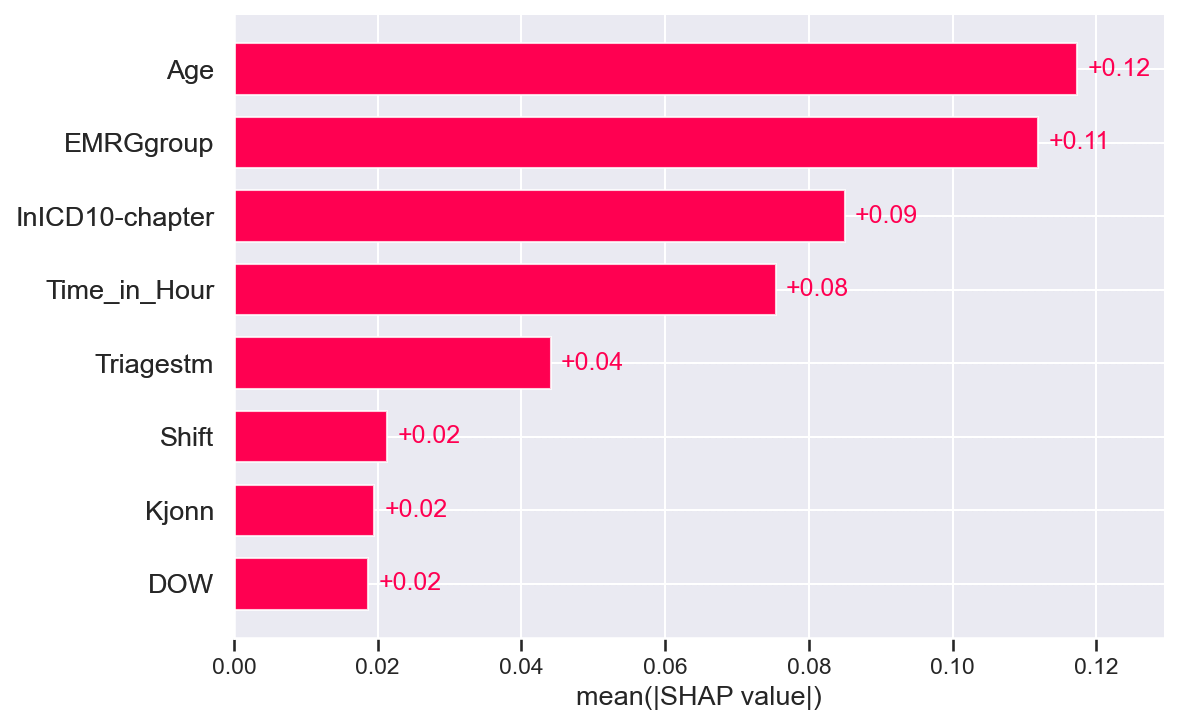

In [19]:
shap.plots.bar(exp,max_display=20)

In [20]:
# shap.summary_plot(exp[:,['EDLOS','Age','Triagestm']])

In [24]:
t.categories_[preprocessor.transformers_[1][2].index('EMRGgroup')],t.categories_[preprocessor.transformers_[1][2].index('InICD10-chapter')],\
t.categories_[preprocessor.transformers_[1][2].index('Shift')],t.categories_[preprocessor.transformers_[1][2].index('DOW')],\
t.categories_[preprocessor.transformers_[1][2].index('Kjonn')],t.categories_[preprocessor.transformers_[1][2].index('Time_in_Hour')]
# exp[:,'EMRGgroup']

(array(['HJERTE', 'KATASTROFE', 'KIR', 'KJKIR', 'KREFT', 'LUNGE', 'MED',
        'MULTITRAUME', 'NEVRO', 'NKIR', 'OT', 'PKIR', 'Rett på post',
        'XXXX', 'ØNH'], dtype=object),
 array(['0', 'A', 'C', 'D', 'E', 'F', 'G', 'I', 'J', 'J ', 'K', 'L', 'M',
        'N', 'R', 'S', 'T', 'X', 'Z'], dtype=object),
 array(['Dag', 'Kveld', 'Natt'], dtype=object),
 array(['Helg', 'Man-fre'], dtype=object),
 array(['Kvinne', 'Mann'], dtype=object),
 array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0,
        13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0,
        24.0], dtype=object))

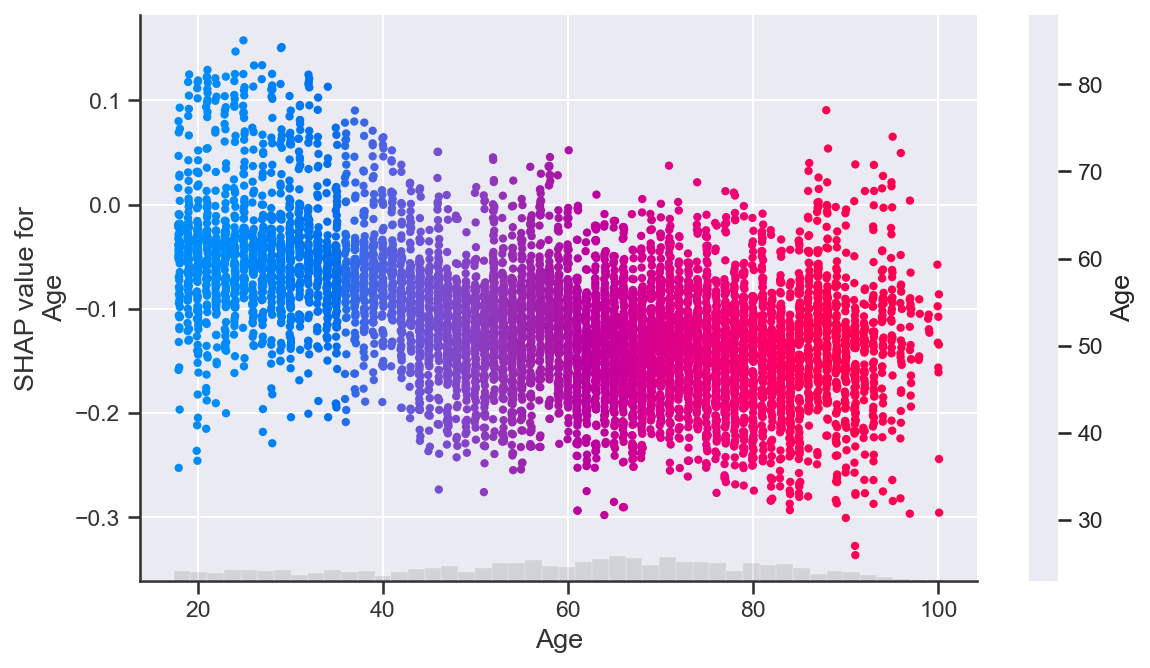

In [22]:

fig, ax = plt.subplots(figsize=(9,5))
num_variable = 'Age'

shap.plots.scatter(exp[:,num_variable],ax=ax,xmax=None, color=exp[:,'Age'])


FixedFormatter should only be used together with FixedLocator


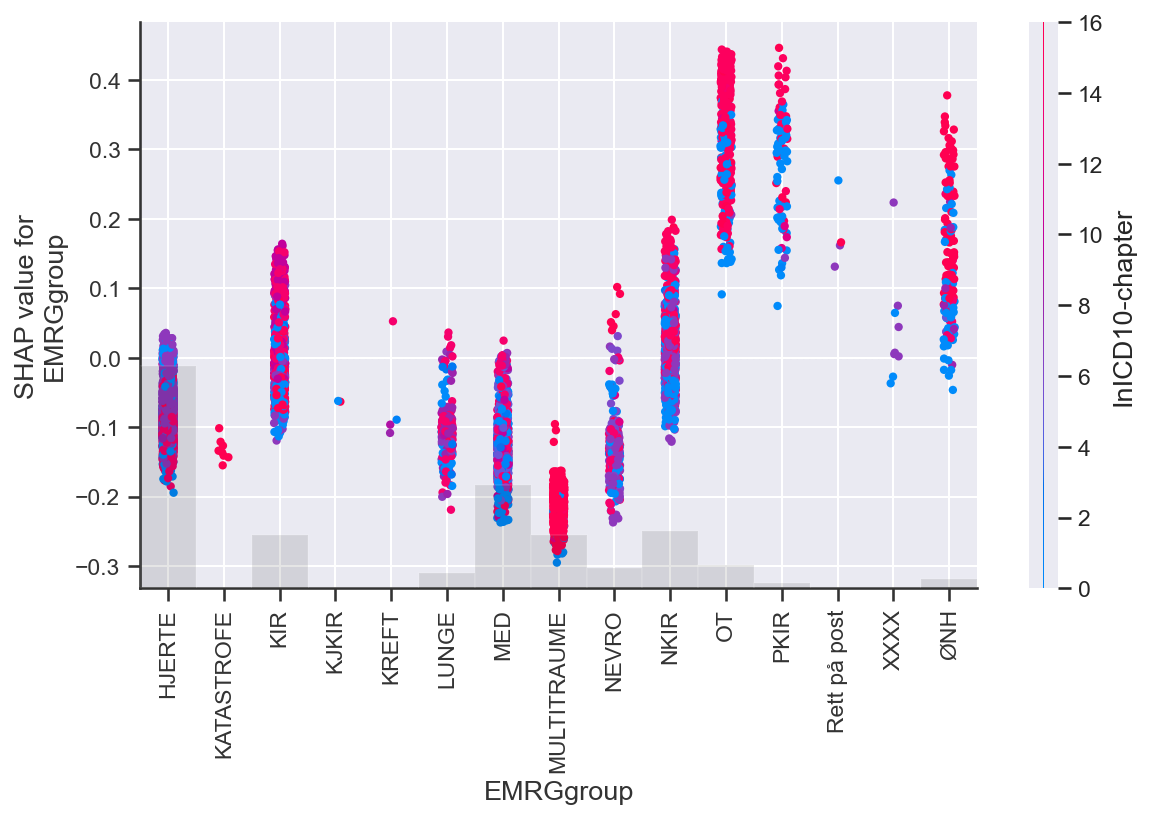

In [33]:
fig, ax = plt.subplots(figsize=(9,5))
cat_variable = 'EMRGgroup'#'InICD10-chapter'#'EMRGgroup'#'Time_in_Hour'#'InICD10-chapter'
t = preprocessor.transformers_[1][1][1]

ax.set_xticklabels(t.categories_[preprocessor.transformers_[1][2].index(cat_variable)],rotation=90)
ax.set_xticks(np.arange(0,len(t.categories_[preprocessor.transformers_[1][2].index(cat_variable)])))
shap.plots.scatter(exp[:,cat_variable],ax=ax, color=exp)#[:,'Age'])



In [20]:
df_data.Dischgto.value_counts()

Bosted              37010
KORTTIDSPOSTEN      16678
OBS-post            14825
Nevro 3             10055
Nevro 2              8612
                    ...  
SOP/kir 1V             14
Hudavd.                12
Lunge 2, Dagpost        9
Nevro 4                 6
OT Rehab                3
Name: Dischgto, Length: 95, dtype: int64

## Risk of misclassifying patients discharged to home 

Population: Patients discharged to home

Classification: Triage < 3 (1) vs >= 3 (0) 

In [88]:
X_h = df_mod.loc[df_mod.Dischgto=='Bosted',features]
y_h = pd.Series(np.where(df_mod.loc[df_mod.Dischgto=='Bosted','Htriage']<3,1,0))
y_h.value_counts()

0    30173
1     1656
dtype: int64

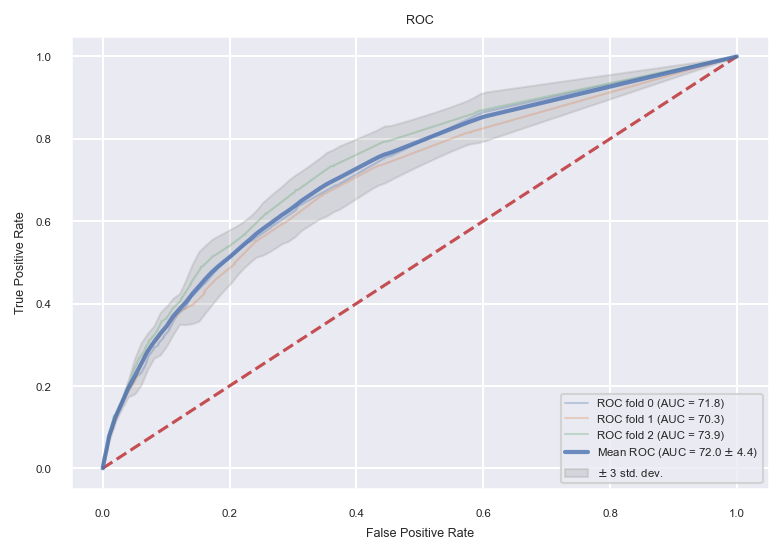

In [89]:
cv=StratifiedKFold(n_splits=3,shuffle=True)
cv_roc(X_h,y_h,rf_clf,cv)

In [90]:

X_h_t = preprocessor.fit_transform(X_h)

cols = preprocessor.transformers_[0][2] + preprocessor.transformers_[1][2]

rf = RandomForestClassifier(random_state=42,class_weight="balanced").fit(X_h_t,y_h)

explainer = shap.TreeExplainer(rf)
shap_values_h = explainer(X_h_t)
exp_h = shap.Explanation(shap_values_h.values[:,:,1], 
                  shap_values_h.base_values[:,1], 
                  data=X_h_t, 
                  feature_names=cols)

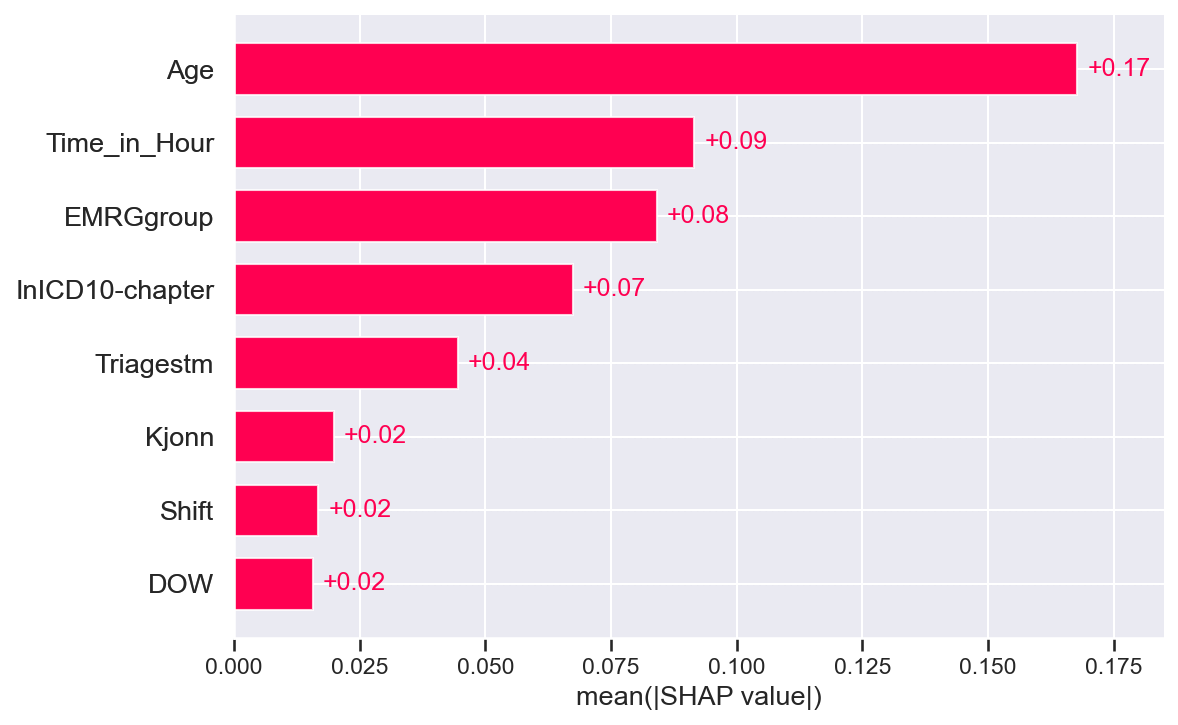

In [91]:
shap.plots.bar(exp_h,max_display=20)

In [92]:
# shap.summary_plot(exp_h[:,['EDLOS','Age','Triagestm']])

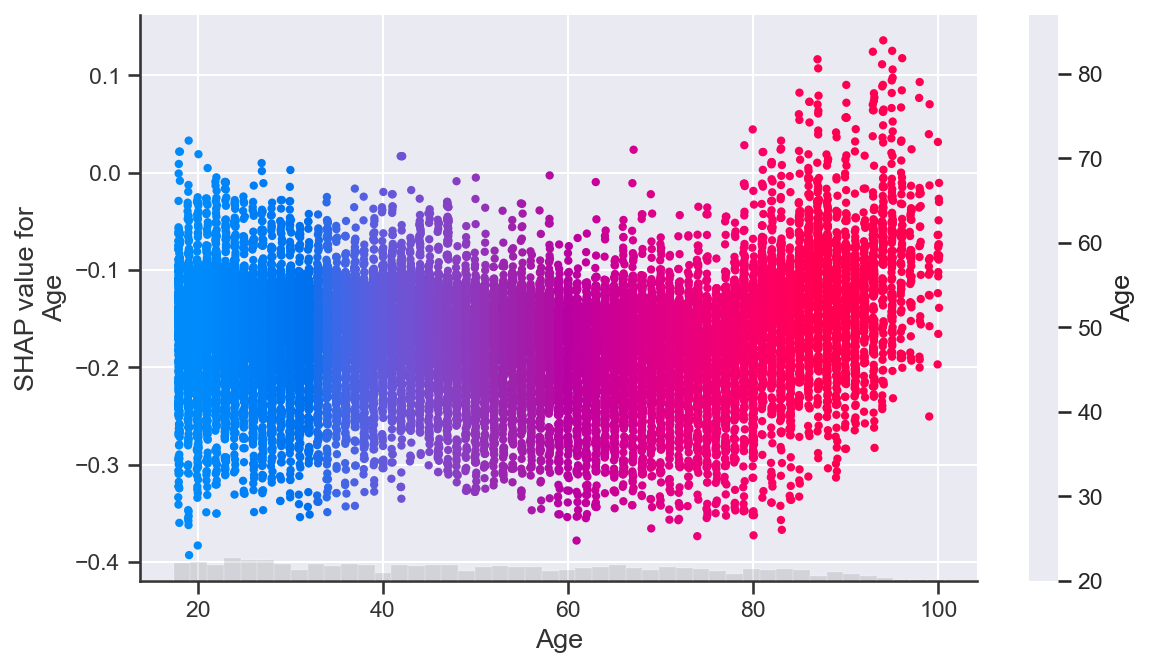

In [93]:

fig, ax = plt.subplots(figsize=(9,5))
num_variable = 'Age'

shap.plots.scatter(exp_h[:,num_variable],ax=ax,xmax=None, color=exp_h[:,'Age'])


FixedFormatter should only be used together with FixedLocator


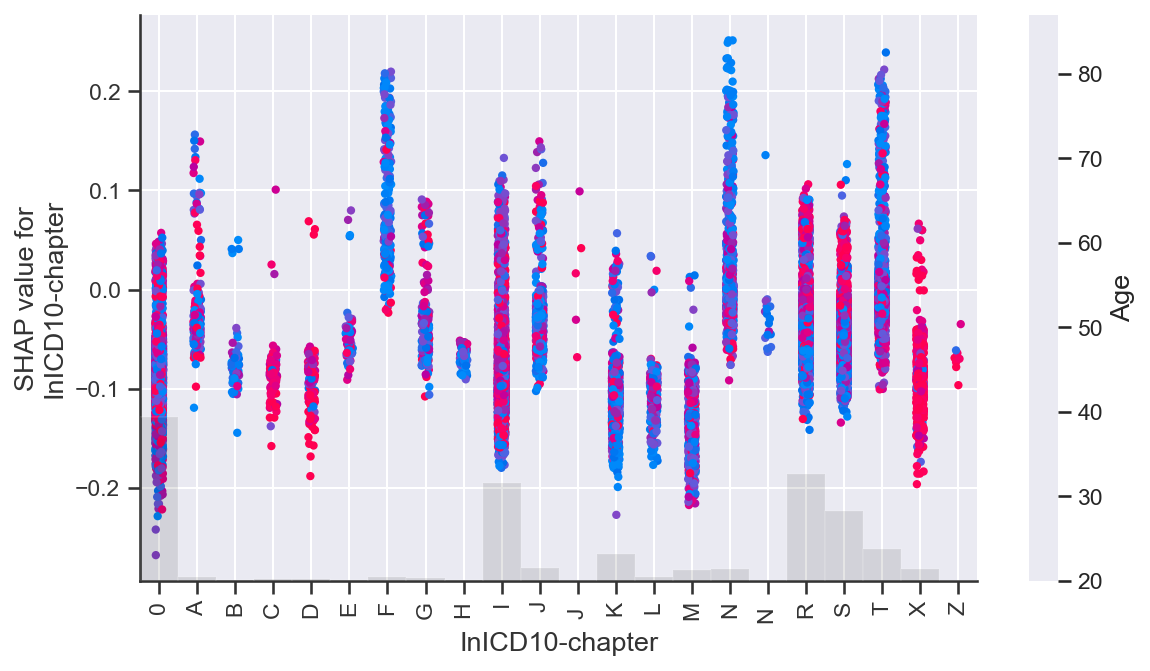

In [94]:
fig, ax = plt.subplots(figsize=(9,5))
cat_variable = 'InICD10-chapter'#'InICD10-chapter'#'EMRGgroup'#'Time_in_Hour'#'InICD10-chapter'
t = preprocessor.transformers_[1][1][1]

ax.set_xticklabels(t.categories_[preprocessor.transformers_[1][2].index(cat_variable)],rotation=90)
ax.set_xticks(np.arange(0,len(t.categories_[preprocessor.transformers_[1][2].index(cat_variable)])))
shap.plots.scatter(exp_h[:,cat_variable],ax=ax, color=exp_h[:,'Age'])

